# Extending the Agent Loop with Capabilities

While tools provide specific functions our agent can use, sometimes we need to extend the agent’s core behavior in more fundamental ways. The Capability pattern allows us to modify multiple aspects of the agent loop while keeping the core logic clean and maintainable.

The idea behind the Capability pattern is to encapsulate specific adaptations of the agent loop inside of a class. This class can be plugged in to modify the behavior of the agent loop without modifying the loop code itself. Agent’s that need more specialized agent loop behavior can be composed by adding capabilities to the agent. The Capability has a lifecycle that begins when the agent loop is about to start and ends when the agent loop is about to terminate. A Capability might open a database connection, log prompts being sent to the LLM, or add metadata to the agent’s responses.

Let’s explore this pattern by implementing something seemingly simple but powerful: making our agent aware of time. An agent that understands time can make better decisions about scheduling, deadlines, and time-sensitive tasks.

##The Capability Pattern
A Capability can interact with the agent loop at multiple points. Looking at our Agent class, we can see these interaction points:

In [ ]:
def run(self, user_input: str, memory=None, action_context_props=None):

    ... existing code ...

    # Initialize capabilities
    for capability in self.capabilities:
        capability.init(self, action_context)

    while True:
        # Start of loop capabilities
        can_start_loop = reduce(lambda a, c: c.start_agent_loop(self, action_context),
                              self.capabilities, False)

        ... existing code ...

        # Construct prompt with capability modifications
        prompt = reduce(lambda p, c: c.process_prompt(self, action_context, p),
                      self.capabilities, base_prompt)

        ... existing code ...

        # Process response with capabilities
        response = reduce(lambda r, c: c.process_response(self, action_context, r),
                        self.capabilities, response)

        ... existing code ...

        # Process action with capabilities
        action = reduce(lambda a, c: c.process_action(self, action_context, a),
                      self.capabilities, action)

        ... existing code ...

        # Process result with capabilities
        result = reduce(lambda r, c: c.process_result(self, action_context, response,
                                                     action_def, action, r),
                       self.capabilities, result)

        ... existing code ...

        # End of loop capabilities
        for capability in self.capabilities:
            capability.end_agent_loop(self, action_context)

Each of these interaction points allows a Capability to modify or enhance the agent’s behavior. Let’s implement time awareness using this pattern.



##Understanding the Capability Class
A Capability can interact with the agent loop at multiple points. Think of these interaction points like hooks or lifecycle events in a web framework - they give us specific moments where we can modify or enhance the agent’s behavior. Let’s examine the Capability class in detail:


In [ ]:
class Capability:
    def __init__(self, name: str, description: str):
        self.name = name
        self.description = description

    def init(self, agent, action_context: ActionContext) -> dict:
        """Called once when the agent starts running."""
        pass

    def start_agent_loop(self, agent, action_context: ActionContext) -> bool:
        """Called at the start of each iteration through the agent loop."""
        return True

    def process_prompt(self, agent, action_context: ActionContext,
                      prompt: Prompt) -> Prompt:
        """Called right before the prompt is sent to the LLM."""
        return prompt

    def process_response(self, agent, action_context: ActionContext,
                        response: str) -> str:
        """Called after getting a response from the LLM."""
        return response

    def process_action(self, agent, action_context: ActionContext,
                      action: dict) -> dict:
        """Called after parsing the response into an action."""
        return action

    def process_result(self, agent, action_context: ActionContext,
                      response: str, action_def: Action,
                      action: dict, result: any) -> any:
        """Called after executing the action."""
        return result

    def process_new_memories(self, agent, action_context: ActionContext,
                           memory: Memory, response, result,
                           memories: List[dict]) -> List[dict]:
        """Called when new memories are being added."""
        return memories

    def end_agent_loop(self, agent, action_context: ActionContext):
        """Called at the end of each iteration through the agent loop."""
        pass

    def should_terminate(self, agent, action_context: ActionContext,
                        response: str) -> bool:
        """Called to check if the agent should stop running."""
        return False

    def terminate(self, agent, action_context: ActionContext) -> dict:
        """Called when the agent is shutting down."""
        pass

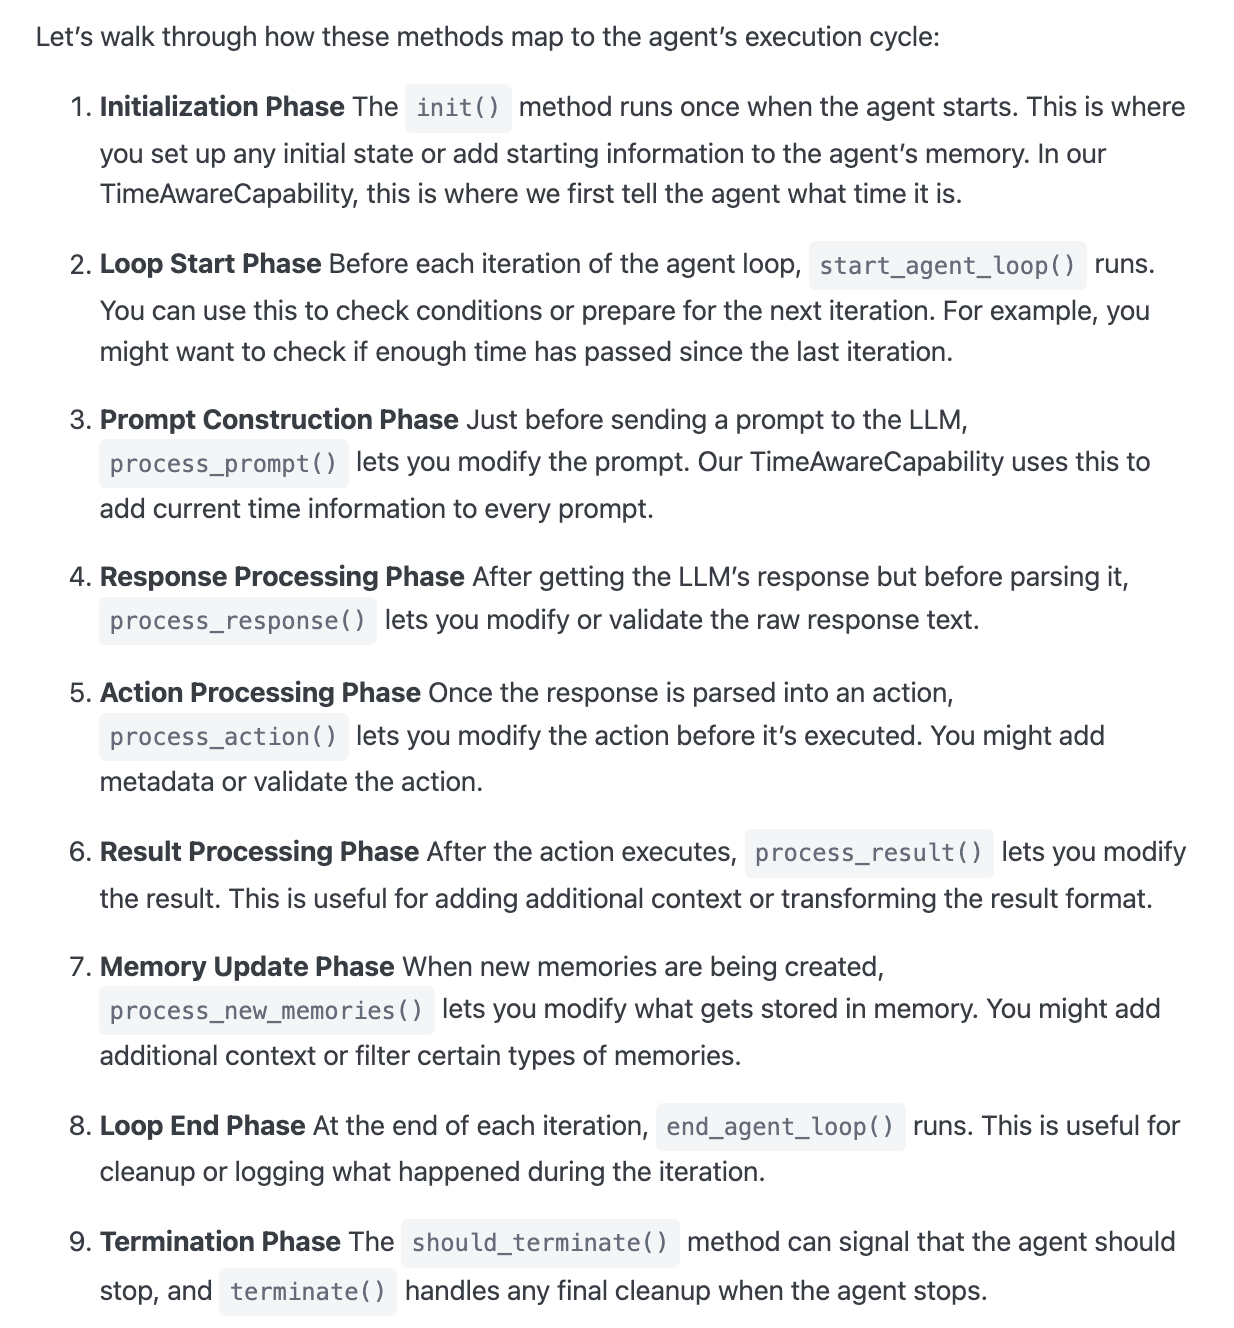

Each of these methods receives both the agent instance and the ActionContext, giving you access to everything you need to modify the agent’s behavior. The agent processes these methods in sequence using Python’s reduce() function:

In [ ]:
# Example from the agent loop
prompt = reduce(lambda p, c: c.process_prompt(self, action_context, p),
               self.capabilities, base_prompt)

Each of these methods receives both the agent instance and the ActionContext, giving you access to everything you need to modify the agent’s behavior. Looking at the Agent constructor, we can see how capabilities become part of the agent:

In [ ]:
class Agent:
    def __init__(self,
                 goals: List[Goal],
                 agent_language: AgentLanguage,
                 action_registry: ActionRegistry,
                 generate_response: Callable[[Prompt], str],
                 environment: Environment,
                 capabilities: List[Capability] = [],
                 max_iterations: int = 10,
                 max_duration_seconds: int = 180):
        """
        Initialize an agent with its core GAME components and capabilities.

        Goals, Actions, Memory, and Environment (GAME) form the core of the agent,
        while capabilities provide ways to extend and modify the agent's behavior.

        Args:
            goals: What the agent aims to achieve
            agent_language: How the agent formats and parses LLM interactions
            action_registry: Available tools the agent can use
            generate_response: Function to call the LLM
            environment: Manages tool execution and results
            capabilities: List of capabilities that extend agent behavior
            max_iterations: Maximum number of action loops
            max_duration_seconds: Maximum runtime in seconds
        """
        self.goals = goals
        self.generate_response = generate_response
        self.agent_language = agent_language
        self.actions = action_registry
        self.environment = environment
        self.capabilities = capabilities or []
        self.max_iterations = max_iterations
        self.max_duration_seconds = max_duration_seconds

This design lets us compose an agent with exactly the capabilities it needs. For example, we might create an agent that’s both time-aware and able to log its actions:



In [ ]:
agent = Agent(
    goals=[
        Goal(name="scheduling",
             description="Schedule meetings considering current time and availability")
    ],
    agent_language=JSONAgentLanguage(),
    action_registry=registry,
    generate_response=llm.generate,
    environment=PythonEnvironment(),
    capabilities=[
        TimeAwareCapability(),
        LoggingCapability(log_level="INFO"),
        MetricsCapability(metrics_server="prometheus:9090")
    ]
)

Each capability in the list gets a chance to participate in every phase of the agent’s execution. The agent processes these methods in sequence using Python’s reduce() function:

The TimeAwareCapability might add time information to a prompt, and then the LoggingCapability could log that time-enhanced prompt before it goes to the LLM.

This architecture allows us to build complex behaviors by composing simple, focused capabilities, each responsible for one aspect of the agent’s behavior. It’s similar to how middleware works in web frameworks, where each piece can modify the request/response cycle without the core application needing to know about these modifications.

##Implementing Time Awareness
The TimeAwareCapability needs to inform the agent about the current time and ensure this information persists throughout its decision-making process:


In [ ]:
from datetime import datetime
from zoneinfo import ZoneInfo

class TimeAwareCapability(Capability):
    def __init__(self):
        super().__init__(
            name="Time Awareness",
            description="Allows the agent to be aware of time"
        )

    def init(self, agent, action_context: ActionContext) -> dict:
        """Set up time awareness at the start of agent execution."""
        # Get timezone from context or use default
        time_zone_name = action_context.get("time_zone", "America/Chicago")
        timezone = ZoneInfo(time_zone_name)

        # Get current time in specified timezone
        current_time = datetime.now(timezone)

        # Format time in both machine and human-readable formats
        iso_time = current_time.strftime("%Y-%m-%dT%H:%M:%S%z")
        human_time = current_time.strftime("%H:%M %A, %B %d, %Y")

        # Store time information in memory
        memory = action_context.get_memory()
        memory.add_memory({
            "type": "system",
            "content": f"""Right now, it is {human_time} (ISO: {iso_time}).
            You are in the {time_zone_name} timezone.
            Please consider the day/time, if relevant, when responding."""
        })

    def process_prompt(self, agent, action_context: ActionContext,
                      prompt: Prompt) -> Prompt:
        """Update time information in each prompt."""
        time_zone_name = action_context.get("time_zone", "America/Chicago")
        current_time = datetime.now(ZoneInfo(time_zone_name))

        # Add current time to system message
        system_msg = (f"Current time: "
                     f"{current_time.strftime('%H:%M %A, %B %d, %Y')} "
                     f"({time_zone_name})\n\n")

        # Add to existing system message or create new one
        messages = prompt.messages
        if messages and messages[0]["role"] == "system":
            messages[0]["content"] = system_msg + messages[0]["content"]
        else:
            messages.insert(0, {
                "role": "system",
                "content": system_msg
            })

        return Prompt(messages=messages)

Now we can use this capability when creating our agent:



In [ ]:
agent = Agent(
    goals=[Goal(name="task", description="Complete the assigned task")],
    agent_language=JSONAgentLanguage(),
    action_registry=registry,
    generate_response=llm.generate,
    environment=PythonEnvironment(),
    capabilities=[
        TimeAwareCapability()
    ]
)

Our agent now consistently knows the current time, enabling it to make time-aware decisions. For example, if we ask it to schedule a meeting, it might respond:

In [ ]:
# Example conversation
agent.run("Schedule a team meeting for today")

# Agent response might include:
"Since it's already 5:30 PM on Friday, I recommend scheduling the meeting
for Monday morning instead. Would you like me to look for available times
on Monday?"

## How Time Awareness Changes Agent Behavior
The TimeAwareCapability modifies agent behavior in several ways:

1. Through init(): When the agent starts, it establishes baseline time awareness by adding time information to memory.

2. Through process_prompt(): Before each prompt, it updates the current time, ensuring the agent always has fresh time data for decision-making.

The capability’s modifications ripple through the agent’s decision-making process while keeping the core agent loop clean. We didn’t need to modify the Agent class at all - the capability pattern handled everything.